<a href="https://colab.research.google.com/github/TanayPhatak/Google_Colab_Projects/blob/main/GAN_for_handwritten_digit_generation_(MNIST_x_PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network
## Generate handwritten digits - similar to MNIST dataset.

### Imports

In [1]:
import torch
from torch import nn
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

torch.manual_seed(42)

### Configurations

In [2]:
device = 'cuda'
batch_size = 128
noise_dim = 64

# Optimizer Parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 20

### Load dataset

In [3]:
train_augs = T.Compose([
                        T.RandomRotation((-20, +20)),
                        T.ToTensor() # (h, w, c) -> (c, h, w)
              ])

In [4]:
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.74MB/s]


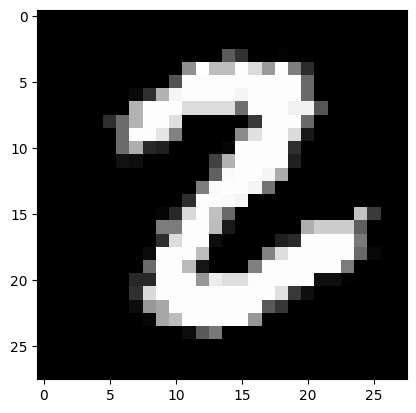

In [5]:
image, label = trainset[25]
plt.imshow(image.squeeze(), cmap='gray')

In [6]:
print("Total number of images in trainset:", len(trainset))

Total number of images in trainset: 60000


### Load dataset into batches

In [7]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [8]:
print("Total number of batches in trainloader:", len(trainloader))

Total number of batches in trainloader: 469


In [9]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(image.shape)

torch.Size([1, 28, 28])


In [10]:
def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

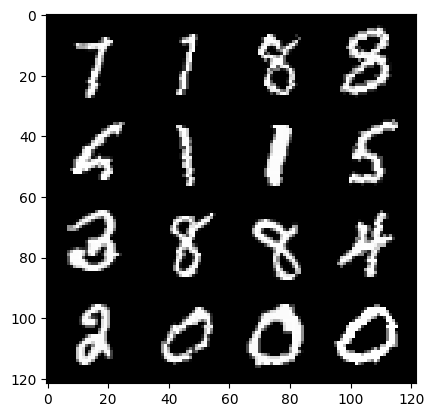

In [11]:
show_tensor_images(images, num_images=16)

### Discriminator Network

In [12]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [13]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [16]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.block1 = get_disc_block(1, 16, (3, 3), 2)
    self.block2 = get_disc_block(16, 32, (5, 5), 2)
    self.block3 = get_disc_block(32, 64, (5, 5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=64, out_features=1)


  def forward(self, images):
    x1 = self.block1(images)
    x2 = self.block2(x1)
    x3 = self.block3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [17]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

### Generator Network

In [18]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator \n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) \n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                               

In [19]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
  if final_block:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )

  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [23]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()
    self.noise_dim = noise_dim

    self.block1 = get_gen_block(noise_dim, 256, (3, 3), 2)
    self.block2 = get_gen_block(256, 128, (4, 4), 1)
    self.block3 = get_gen_block(128, 64, (3, 3), 2)
    self.block4 = get_gen_block(64, 1, (4, 4), 2, final_block=True)


  def forward(self, r_noise_vec):
    # (bs, noise_dim) -> (bs, noise_dim, 1, 1)

    x = r_noise_vec.view(-1, self.noise_dim, 1, 1)

    x1 = self.block1(x)
    x2 = self.block2(x1)
    x3 = self.block3(x2)
    x4 = self.block4(x3)

    return x4

In [24]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [25]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [26]:
D = D.apply(weights_init)
G = G.apply(weights_init)

### Loss function and Load optimizer

In [27]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(disc_pred, torch.ones_like(disc_pred))
  return loss


def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(disc_pred, torch.zeros_like(disc_pred))
  return loss

In [28]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

### Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 | D_loss: 0.633668246553905 | G_loss: 0.8433134014418384


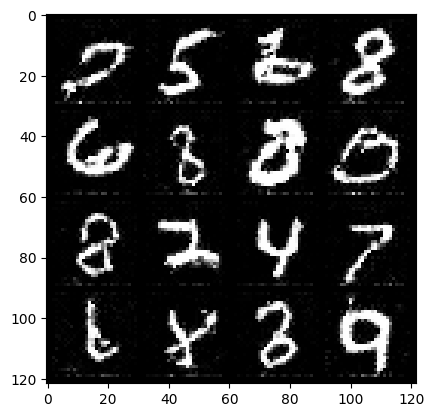

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | D_loss: 0.6319008056543021 | G_loss: 0.8417058396441087


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | D_loss: 0.6303921366042928 | G_loss: 0.8494457134814151


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | D_loss: 0.629827491001788 | G_loss: 0.849239106117281


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | D_loss: 0.6307183115212902 | G_loss: 0.8522316864304451


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | D_loss: 0.6292378436019426 | G_loss: 0.8545612200999311


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | D_loss: 0.6278536399798607 | G_loss: 0.8555092262560879


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | D_loss: 0.6280397652054647 | G_loss: 0.8584513000842097


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 | D_loss: 0.6260442474503507 | G_loss: 0.8603386787463353


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | D_loss: 0.6252267312393514 | G_loss: 0.8642118626566075


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | D_loss: 0.6234569876178749 | G_loss: 0.8696104300810076


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | D_loss: 0.6227480457789862 | G_loss: 0.8753737063804415


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 | D_loss: 0.6194787480429546 | G_loss: 0.8794079523350893


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 | D_loss: 0.6208502966712024 | G_loss: 0.8793637297555074


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 | D_loss: 0.6179175280304606 | G_loss: 0.8854577734526287


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 | D_loss: 0.6188197770098379 | G_loss: 0.88497843658492


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 | D_loss: 0.619641264491498 | G_loss: 0.8893179899848092


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 | D_loss: 0.6188571680583426 | G_loss: 0.8908186285480507


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 | D_loss: 0.6179536162917294 | G_loss: 0.890961952682243


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 | D_loss: 0.6170710078688827 | G_loss: 0.8951758624139879


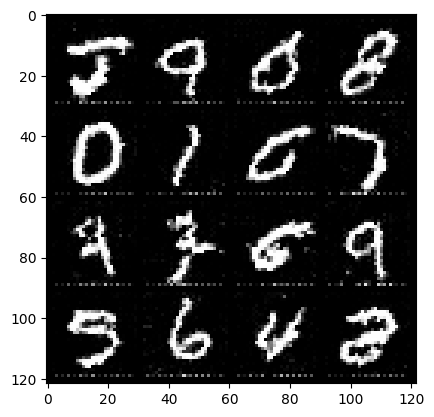

In [36]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device=device)

    # Find loss and update weights for D
    D_opt.zero_grad()
    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss) / 2
    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    # Find loss and update weights for G
    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device=device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)
    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()


  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch: {} | D_loss: {} | G_loss: {}".format(i+1, avg_d_loss, avg_g_loss))

  if i in [0, epochs-1]:
    show_tensor_images(fake_img)

### Save and test loading generator and discriminator

In [42]:
torch.save(D.state_dict(), 'discriminator.pth')
torch.save(G.state_dict(), 'generator.pth')

In [44]:
Disc = Discriminator()
Disc.load_state_dict(torch.load('discriminator.pth', weights_only=True))

Gen = Generator(noise_dim)
Gen.load_state_dict(torch.load('generator.pth', weights_only=True))

<All keys matched successfully>

In [47]:
Disc.eval()

Discriminator(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [48]:
Gen.eval()

Generator(
  (block1): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)